In [1]:
import graph_tool.all as gt
import pandas as pd
import numpy as np



/home/guillaume/anaconda/envs/python3/lib/python3.4/site-packages/graph_tool/draw/cairo_draw.py:1318: RuntimeWarning: Error importing Gtk module: No module named 'gi'; GTK+ drawing will not work.
  warnings.warn(msg, RuntimeWarning)


### A new approach to pandas integration to graph_tool

In [2]:
%pdb

Automatic pdb calling has been turned ON


In [3]:
def draw(graph, is_cell_vert, is_junction_edge):
    not_junction = is_junction_edge.copy()
    not_junction.a = 1 - is_junction_edge.a
    gt.graph_draw(graph, pos_vp, inline=True,
                  vertex_fill_color=is_cell_vert,
                  edge_color=not_junction,
                  output_size=(300, 300))

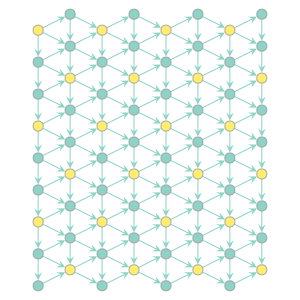

In [4]:
def base_grid(n_cells_x, n_cells_y,
              delta_x=1, delta_y=1):

    n_x = n_cells_x
    n_y = n_cells_y * 3

    xy_grid = np.mgrid[:n_x, :n_y]

    xs = xy_grid[0].astype('float')
    ys = xy_grid[1].astype('float')

    ys[::2, ...] += 0.5
    is_cell_vert = np.zeros_like(xy_grid[1]).astype(np.bool)
    is_cell_vert[::2, ::3] = 1
    is_cell_vert[1::2, 2::3] = 1
    is_cell_vert = is_cell_vert.flatten()

    pos = np.zeros((n_x * n_y, 2))
    pos[:, 0] = xs.flatten() * delta_x
    pos[:, 1] = ys.flatten() * delta_y

    return pos, is_cell_vert






pos, _is_cell_vert = base_grid(8, 3)

graph, pos_vp = gt.geometric_graph(pos, 1.415)
graph.set_directed(True)
graph.vp['x'], graph.vp['y'] = gt.ungroup_vector_property(pos_vp, [0, 1])
graph.vp['z'] = graph.new_vertex_property('double')
graph.vp['z'].a = 1.

is_cell_vert = graph.new_vertex_property('bool')
is_cell_vert.a = _is_cell_vert

is_junction_edge = graph.new_edge_property('bool')
graph.edge_properties['is_junction_edge'] = is_junction_edge
graph.vertex_properties['is_cell_vert'] = is_cell_vert

draw(graph, is_cell_vert, is_junction_edge)


Flipping 62 edges


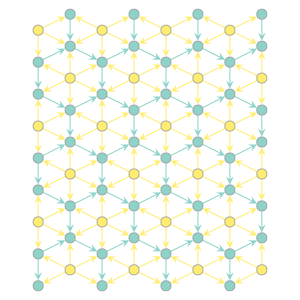

In [5]:
def reorient_edges(graph, is_cell_vert, is_junction_edge):

    to_flip = []
    for edge in graph.edges():
        srce, trgt = edge
        if is_cell_vert[srce] and not is_cell_vert[trgt]:
            is_junction_edge[edge] = 0
        elif not is_cell_vert[srce] and is_cell_vert[trgt]:
            ### Flip the edge
            to_flip.append(edge)
        elif is_cell_vert[srce] and is_cell_vert[trgt]:
            raise ValueError(
                'Invalid cell to cell edge {}'.format(edge))
        else:
            is_junction_edge[edge] = 1

    print('Flipping {} edges'.format(len(to_flip)))
    for edge in to_flip:
        new = graph.add_edge(edge.target(), edge.source())
        is_junction_edge[new] = 0
        graph.remove_edge(edge)
    
reorient_edges(graph, is_cell_vert, is_junction_edge)
#graph.set_edge_filter(is_junction_edge)
draw(graph, is_cell_vert, is_junction_edge)
#graph.set_edge_filter(None)


In [6]:
def get_faces(graph, as_array=True):
    '''
    Retrieves all the triangular subgraphs of the form

       1 -- > 2
        ^   ^
         \ /
          0

    In our context, vertex 0 always corresponds to a cell
    and vertices 1 and 2 to junction vertices

    Parameters
    ----------

    graph : a :class:`GraphTool` graph instance
    as_array: bool, optional, default `True`
      if `True`, the output of `subraph_isomorphism` is converted
      to a (N, 3) ndarray.

    Returns
    -------

    triangles: (N_t, 3) ndarray
      each line corresponds to a triplet (cell, jv0, jv1)
      where cell, jv0 and jv1 are indices of the input graph
      
      if as_array is False, returns instead the template triangle 3-graph
      and a list of ProperyMaps as returned by `gt.subgraph_isomorphism`
      
    '''
    tri_graph = gt.Graph()
    ## the vertices
    verts = tri_graph.add_vertex(3)
    ## edges
    tri_graph.add_edge_list([(0, 1), (0, 2), (1, 2)])
    _triangles = gt.subgraph_isomorphism(tri_graph, graph)
    if not as_array:
        return tri_graph, _triangles
    triangles = np.array([tri.a for tri in _triangles], dtype=np.int)
    return triangles


In [7]:
triangles = get_faces(graph)

In [8]:
triangles[:5]

array([[ 0,  1, 10],
       [ 0,  9, 10],
       [ 3,  2, 12],
       [ 3,  4, 13],
       [ 3, 12, 13]])

In [9]:
triangles.shape

(112, 3)

In [10]:
face_data = {
    ## Normal
    'ux': (0., np.float),
    'uy': (0., np.float),
    'uz': (0., np.float)}

names =('cell', 'jv_i', 'jv_j')
letters = ('a', 'i', 'j')
tix_aij = pd.MultiIndex.from_arrays(triangles.T,
                                    names=names)
faces = pd.DataFrame(index=tix_aij,
                     columns=face_data.keys())
for key, tup in face_data.items():
    faces[key] = np.ones(triangles.shape[0], dtype=tup[1]) * tup[0]


In [11]:
faces.xs(13, level='jv_i')

,,uy,ux,uz
cell,jv_j,,,
14,22,0,0,0
21,22,0,0,0


In [12]:
faces.dtypes

uy    float64
ux    float64
uz    float64
dtype: object

In [13]:
cells = gt.GraphView(graph, vfilt=is_cell_vert)
junctions = gt.GraphView(graph, efilt=is_junction_edge)

In [14]:
class VertexFacesView:
    '''constructor class to get and set
    data on the columns of a dataframe with repeated values
    for each vertex of the graph'''
    def __init__(self, graph, faces_idx):
        self.graph = graph # Can be a GraphView
        self._idx = faces_idx

    def __getitem__(self, prop_name):
        if isinstance(prop_name, list):
            props = np.array([self.graph.vp[prop_n].a[self._idx]
                              for prop_n in prop_name]).T
            return pd.DataFrame(data=props, index=self._idx,
                                columns=prop_name)
        else:
            prop = graph.vp[prop_name]
            return pd.Series(prop.a[self._idx],
                             index=self._idx, name=prop_name)

    def __setitem__(self, prop_name, data):
        if isinstance(prop_name, list):
            for prop_n, col in zip(prop_name, data):
                self.graph.vp[prop_n].fa = col
        else:
            graph.vp[prop_name].fa = data

class EdgeFacesView:
    '''constructor class to get and set
    data on the columns of a dataframe with repeated values
    for each vertex of the graph'''
    def __init__(self, graph, faces_idx):
        
        self.graph = graph # Can be a GraphView
        self.faces_idx = faces_idx
        self._idx = [graph.edge_index[graph.edge(s, t)]
                     for s, t in faces_idx]
        
    def __getitem__(self, prop_name):
        if isinstance(prop_name, list):
            props = np.array([self.graph.ep[prop_n].a[self._idx]
                              for prop_n in prop_name]).T
            return pd.DataFrame(data=props, index=self._idx,
                                columns=prop_name)
        else:
            prop = self.graph.ep[prop_name]
            return pd.Series(prop.a[self._idx],
                             index=self.faces_idx,
                             name=prop_name)

    def __setitem__(self, prop_name, data):
        if isinstance(prop_name, list):
            for prop_n, col in zip(prop_name, data):
                self.graph.ep[prop_n].fa = col
        else:
            self.graph.ep[prop_name].fa = data
        
def test_vertex_faces_view(graph, faces_idx):
    
    
    fview = VertexFacesView(graph, faces_idx)
    prop = graph.new_vertex_property('long', 0)
    graph.vertex_properties['test'] = prop
    view = fview['test']
    repeats = np.bincount(fview._idx)
    assert view.shape[0] == repeats.sum()
    
    r0 = repeats[0]
    v0 = graph.vertex(fview._idx[0])
    prop[v0] = 100
    np.testing.assert_array_equal(fview['test'].iloc[:repeats[0]],
                                  np.ones(repeats[0]) * 100)
    
    fview['test'] = np.ones(graph.num_vertices(), dtype=np.int)
    
    np.testing.assert_array_equal(prop.fa,
                                  np.ones(prop.fa.shape[0],
                                          dtype=np.int))
    
def test_edge_faces_view(graph, faces_idx):
    
    
    fview = EdgeFacesView(graph, faces_idx)
    prop = graph.new_edge_property('bool', 0)
    graph.edge_properties['test'] = prop
    view = fview['test']
    repeats = np.bincount(fview._idx)
    assert view.shape[0] == repeats.sum()
    
    r0 = repeats[0]
    e0 = graph.edge(*fview.faces_idx[0])
    prop[e0] = 1
    #view = fview['test']
    np.testing.assert_array_equal(fview['test'].iloc[:repeats[0]],
                                  np.ones(repeats[0]))
    
    fview['test'] = np.ones(graph.num_edges(), dtype=np.int)
    
    np.testing.assert_array_equal(prop.fa,
                                  np.ones(prop.fa.shape[0],
                                          dtype=np.int))

In [15]:
idx_a = faces.index.get_level_values('cell')
idx_ij = faces.index.droplevel('cell')

In [16]:
test_vertex_faces_view(graph, idx_a)
test_edge_faces_view(junctions, idx_ij)

In [17]:
cells = gt.GraphView(graph, vfilt=is_cell_vert)
junctions = gt.GraphView(graph, efilt=is_junction_edge)

v_fview = VertexFacesView(cells, idx_a)
e_fview = EdgeFacesView(junctions, idx_ij)

In [18]:
graph.ep['dx'] = graph.new_edge_property('double')
graph.ep['dx'].a = (gt.edge_endpoint_property(graph, graph.vp['x'], 'target').a
                        - gt.edge_endpoint_property(graph, graph.vp['x'], 'source').a)
graph.ep['dy'] = graph.new_edge_property('double')
graph.ep['dy'].a = (gt.edge_endpoint_property(graph, graph.vp['y'], 'target').a
                        - gt.edge_endpoint_property(graph, graph.vp['y'], 'source').a)
graph.ep['dz'] = graph.new_edge_property('double')
graph.ep['dz'].a = (gt.edge_endpoint_property(graph, graph.vp['z'], 'target').a
                        - gt.edge_endpoint_property(graph, graph.vp['z'], 'source').a)


In [19]:
np.sum?

In [20]:
v_fview = VertexFacesView(graph, idx_a)
e_fview = EdgeFacesView(graph, idx_ij)


In [21]:
graph.set_edge_filter(is_junction_edge)
print(graph.ep['dx'].fa)
graph.set_edge_filter(None)


[ 1.  0.  1.  1.  0.  1.  1.  0.  0.  1.  1.  0.  1.  1.  0.  1.  0.  1.
  1.  0.  1.  1.  1.  0.  0.  1.  1.  0.  1.  1.  0.  1.  1.  0.  1.  1.
  0.  1.  1.  0.  0.  1.  1.  0.  1.  1.  0.  1.  1.  0.  1.  1.  0.  1.
  1.  0.  0.  0.  0.]


In [22]:
class Triangles:
    '''
    Data structure defined to index the ensembles of sub-graph homologue to
    this topology:

     jv_i (i) -- > (j) jv_j
           ^       ^
            \     /
             \   /
              (a) cell

    In the 3D coordinate system, this represents an oriented
    triangular face.  Note that as long as the cell to junction edges
    go outward from the cell, the complete epithelium is a unique
    set of faces homologue to this topology (regardess of the
    orientation of jv_i and jv_j) thus the triangle is the unit element
    of the geometrical network - in the cristalography sense of unit
    element.

    '''

    def __init__(self, triangles, graph):
        '''
        Creates a container class for the triangles geometry

        Parameters
        ----------

        triangles: ndarray
          trianges is a (N_t, 3) 2D array where each line contains
          a triple with the indices of the cell, the source (jv_i)
          and the target (jv_j) junction vertices.

        graph: gt.Graph
          the apical junctions network
          

        See Also
        --------

        hdfgraph.graph_to_dataframes: utility to convert a graph_tool.Graph
          to a dataframe pairs
        leg_joint.topology.get_faces: utility to obtain  the triangles list
          from a graph

        '''
        self.triangles_array = triangles
        self.graph = graph

        
        self.coords = ['x', 'y', 'z']
        self.dcoords = ['d'+c for c in self.coords]
        self.normal_coords = ['u'+c for c in self.coords]

        self._build_indices(triangles)
        self.faces = pd.DataFrame(index=self.tix_aij,
                                  columns=face_data.keys())
        #self.grad_array = pd.DataFrame(index=self.uix_active,
        #                               columns=self.coords)
        #self.grad_array[:] = 0
        
        
        
    def copy(self):
        return Triangles(self.triangles_array.copy(),
                         self.vertex_df.copy(),
                         self.edge_df.copy())

    def _build_indices(self, faces):

        self.indices = {}
        names =('cell', 'jv_i', 'jv_j')
        letters = ('a', 'i', 'j')

        
        
        #self.uix_active = self.vertex_df[
        #    self.vertex_df.is_active_vert==1].index

        ### MultiIndex named (cell, jv_i, jv_j) for each triangle
        ### Those indices must be coherent with the original graph
        self.tix_aij = pd.MultiIndex.from_arrays(faces.T,
                                                 names=names)
        for letter, name  in zip(letters, names):

            ### single level index on current
            ### vertex type (contains repeated values)
            idx_name = 'tix_{}'.format(letter)
            idx = self.tix_aij.get_level_values(name)
            setattr(self, idx_name, idx)
            self.indices[name] = idx


            unique = idx.unique()
            unique_name = 'uix_{}'.format(letter)
            setattr(self, unique_name, unique)

            ### 2 level MultiIndex on the oriented edge opposed
            ### to the current vertex
            other_letters = list(letters)
            other_letters.remove(letter)
            other_names = list(names)
            other_names.remove(name)

            idx_name = 'tix_{}{}'.format(*other_letters)
            idx = self.tix_aij.droplevel(name)
            setattr(self, idx_name, idx)

            unique_name = 'uix_{}{}'.format(*other_letters)
            unique = idx.unique()
            setattr(self, unique_name, unique)

        #self.uix_active_i = np.array(
        #    list(set(self.uix_active).intersection(self.uix_i)))
        #self.uix_active_j = np.array(
        #    list(set(self.uix_active).intersection(self.uix_j)))


In [23]:
triangles = Triangles(triangles, graph)

In [24]:
triangles

In [25]:
tdf_atoj = EdgeFacesView(graph, triangles.tix_aj)
tdf_atoi = EdgeFacesView(graph, triangles.tix_ai)


In [26]:
r_ak = tdf_atoi[triangles.dcoords].set_index(triangles.tix_aij)
r_am = tdf_atoj[triangles.dcoords].set_index(triangles.tix_aij)

crosses = pd.DataFrame(np.cross(r_ak, r_am), index=triangles.tix_aij)

In [27]:
crosses.head()

0  1  2
cell jv_i jv_j         
0    1    10    0  0 -1
     9    10   -0  0  1
3    2    12    0  0  1
     4    13    0  0 -1
     12   13   -0  0  1

In [28]:
sub_area = np.linalg.norm(crosses, axis=1) / 2
triangles.faces['sub_area'] = sub_area

In [29]:
triangles.faces['sub_area'].head()

cell  jv_i  jv_j
0     1     10      0.5
      9     10      0.5
3     2     12      0.5
      4     13      0.5
      12    13      0.5
Name: sub_area, dtype: float64

In [30]:
areas = triangles.faces['sub_area'].sum(level='cell')

In [31]:
triangles.faces.head()

uy   ux   uz  sub_area
cell jv_i jv_j                         
0    1    10    NaN  NaN  NaN       0.5
     9    10    NaN  NaN  NaN       0.5
3    2    12    NaN  NaN  NaN       0.5
     4    13    NaN  NaN  NaN       0.5
     12   13    NaN  NaN  NaN       0.5

In [32]:
areas

cell
0     1.0
3     1.5
6     1.5
11    3.0
14    3.0
17    2.0
18    2.0
21    3.0
24    3.0
29    3.0
32    3.0
35    2.0
36    2.0
39    3.0
42    3.0
47    3.0
50    3.0
53    2.0
54    2.0
57    3.0
60    3.0
65    1.5
68    1.5
71    1.0
Name: sub_area, dtype: float64

In [33]:
cells = gt.GraphView(graph, is_cell_vert)
cells.vp['area'] = cells.new_vertex_property('float')

cells.vp['area'].fa = areas

In [35]:
for cell in cells.vertices():
    print(cell, cells.vp['area'][cell])

0 1.0
3 1.5
6 1.5
11 3.0
14 3.0
17 2.0
18 2.0
21 3.0
24 3.0
29 3.0
32 3.0
35 2.0
36 2.0
39 3.0
42 3.0
47 3.0
50 3.0
53 2.0
54 2.0
57 3.0
60 3.0
65 1.5
68 1.5
71 1.0


In [36]:
graph.vp['height'] = graph.new_vertex_property('double')
graph.vp['height'].a = 1.

In [43]:
graph.vertex_properties.keys()

dict_keys(['y', 'is_cell_vert', 'z', 'x', 'height', 'test'])

In [40]:
graph.ep['edge_length'] = graph.new_edge_property('double')
graph.ep['edge_length'].a = np.sqrt((graph.ep['dx'].a
                                     + graph.ep['dy'].a
                                     + graph.ep['dz'].a)**2)

tdf_itoj = EdgeFacesView(graph, triangles.tix_ij)

faces['ell_ij'] = tdf_itoj['edge_length'].values

In [42]:
faces.ell_ij

cell  jv_i  jv_j
0     1     10      0.5
      9     10      1.0
3     2     12      1.5
      4     13      0.5
      12    13      1.0
6     5     15      1.5
      7     16      0.5
      15    16      1.0
11    1     2       1.0
            10      0.5
      2     12      1.5
      10    19      1.5
      12    20      0.5
      19    20      1.0
14    4     5       1.0
            13      0.5
      5     15      1.5
      13    22      1.5
      15    23      0.5
      22    23      1.0
17    7     8       1.0
            16      0.5
      16    25      1.5
      25    26      1.0
18    9     10      1.0
      10    19      1.5
      19    28      0.5
      27    28      1.0
21    12    13      1.0
            20      0.5
                   ... 
50    51    59      0.5
      58    59      1.0
53    43    44      1.0
            52      0.5
      52    61      1.5
      61    62      1.0
54    45    46      1.0
      46    55      1.5
      55    64      0.5
      63    64      1.0

In [44]:
cells.vp['vol'] = cells.new_vertex_property('double')
cells.vp['vol'].fa = cells.vp['height'].fa * cells.vp['area'].fa

KeyError: ('v', 'height')

> /home/guillaume/anaconda/envs/python3/lib/python3.4/site-packages/graph_tool/__init__.py(1692)<lambda>()
   1691         return PropertyDict(self, self.__get_specific_properties("v"),
-> 1692                             lambda g, k: g.__properties[("v", k)],
   1693                             lambda g, k, v: g.__set_property("v", k, v),

ipdb> c
